In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Edit variables in this cell to change the appearance
# of the generated puzzle. 

# Begin parameters
nIts = 200
partitionCountHor = 5
partitionCountVert = 5
graphWidth = partitionCountHor*6
graphHeight = partitionCountVert*6
# End parameters

def transformedx(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2
    x = x-centerx
    y = y-centery
    a ,b ,c ,d  = 2, 0.01, .03, 1

    # Transformation in x
    x = x+.5*np.cos(1.5*y)
    x = (a*c*(x**2+y**2)+(a*d+b*c)*x+b*d)/((c*x+d)**2+(c*y)**2) 
    return x
    

def transformedy(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2
    x = x-centerx
    y = y-centery
    a ,b ,c ,d  = 2, 0.01, .03, 1

    # Transformation in y
    y = ((a*d-b*c)*y)/((c*x+d)**2+(c*y)**2)
    return y


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


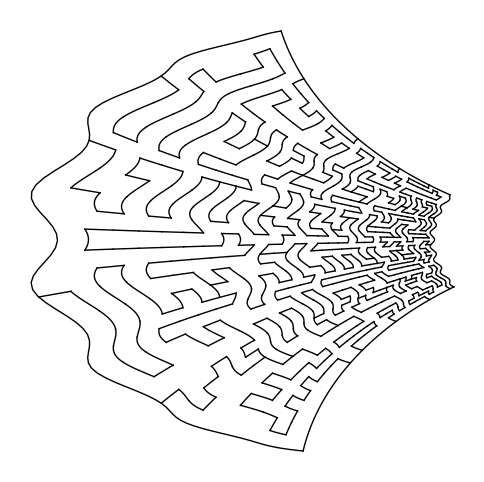

In [ ]:
# The contents of this cell should only be edited if you are trying to make changes 
# to the algorithm that generates the puzzle. 

# Returns whether a piece is adjacent to another partition
def interiorPiece(partition, eater):
    return leftInterior(partition, eater) and rightInterior(partition, eater) and topInterior(partition,eater) and botInterior(partition,eater)

def leftInterior(partition, eater):
    return [eater[0]-1,eater[1]] in partition or eater[0]==0

def rightInterior(partition, eater):
    return [eater[0]+1,eater[1]] in partition or eater[0]==graphWidth-1

def topInterior(partition, eater):
    return [eater[0],eater[1]+1] in partition or eater[1]==graphHeight-1

def botInterior(partition, eater):
    return [eater[0],eater[1]-1] in partition or eater[1]==0

# Returns whether a piece is adjacent to the boundary of the entire puzzle.
# This is used to keep the partitions on the boundary from eating partitions too much
def boundaryPiece(eater):
    return eater[0]==graphWidth or eater[0]==0 or eater[1]==graphHeight-1 or eater[1]==0

# Returns whether the piece attempting to be eaten falls within the boundary of the entire puzzle. 
def eatenNotInRange(eaten):
    return eaten[0] < 0 or eaten[1] < 0 or \
           eaten[0] > graphWidth-1 or eaten[1] > graphHeight -1

# Using a local check, this returns whether eating a given piece will break a partition into two 
# nonconnected regions. 
def noBreak(eatenPartition, eaten):

    # Protects pieces from getting too small
    if len(eatenPartition) < 6:
        return False
    
    UL = [eaten[0]-1,eaten[1]+1] in eatenPartition
    U =  [eaten[0],eaten[1]+1] in eatenPartition
    UR = [eaten[0]+1,eaten[1]+1] in eatenPartition
    L =  [eaten[0]-1,eaten[1]] in eatenPartition
    R =  [eaten[0]+1,eaten[1]] in eatenPartition
    BL = [eaten[0]-1,eaten[1]-1] in eatenPartition
    B =  [eaten[0],eaten[1]-1] in eatenPartition
    BR = [eaten[0]+1,eaten[1]-1] in eatenPartition

    topRowAllIn   = UL and U and UR 
    botRowAllIn   = BL and B and BR 
    leftColAllIn  = UL and L and BL 
    rightColAllIn = UR and R and BR 
    topRowAllGone   = not(UL or U or UR )
    botRowAllGone   = not(BL or B or BR )
    leftColAllGone  = not(UL or L or BL )
    rightColAllGone = not(UR or R or BR )
    
    # exceptions:
    square = (topRowAllGone and leftColAllGone and BR) or \
             (topRowAllGone and rightColAllGone and BL) or \
             (botRowAllGone and leftColAllGone and UR) or \
             (botRowAllGone and rightColAllGone and UL)
    
    tPiece = (topRowAllGone and not L and not R and B) or \
             (botRowAllGone and not L and not R and U) or \
             (leftColAllGone and not U and not B and R) or \
             (rightColAllGone and not U and not B and L)
    
    rectPiece = (botRowAllIn and   L and R) or \
                (topRowAllIn and   L and R) or \
                (rightColAllIn and U and B) or \
                (leftColAllIn and  U and B)
    
    lPiece = (topRowAllGone and leftColAllGone and not BR and B and R) or \
             (topRowAllGone and rightColAllGone and not BL and B and L) or \
             (botRowAllGone and leftColAllGone and not UR and U and R) or \
             (botRowAllGone and rightColAllGone and not UL and U and L)

    if lPiece:
        return False
    
    if square or tPiece or rectPiece:
        return True
    
    # rule:
    if (not topRowAllIn and not botRowAllIn and not leftColAllGone and not rightColAllGone) or \
       (not leftColAllIn and not rightColAllIn and not topRowAllGone and not botRowAllGone):
        return False

    return True

# checks whether a square will be made in the partition of the eater by eating
def noSquare(partition, eaten):
    UL = [eaten[0]-1,eaten[1]+1] in partition
    U =  [eaten[0],eaten[1]+1] in partition
    UR = [eaten[0]+1,eaten[1]+1] in partition
    L =  [eaten[0]-1,eaten[1]] in partition
    R =  [eaten[0]+1,eaten[1]] in partition
    BL = [eaten[0]-1,eaten[1]-1] in partition
    B =  [eaten[0],eaten[1]-1] in partition
    BR = [eaten[0]+1,eaten[1]-1] in partition
    topRowAllGone   = not(UL or U or UR )
    botRowAllGone   = not(BL or B or BR )
    leftColAllGone  = not(UL or L or BL )
    rightColAllGone = not(UR or R or BR )

    return not (R and BR and B) and \
           not (L and BL and L) and \
           not (R and UR and U) and \
           not (L and UL and U)
# End functions

# Generates rectangular partitions
partitionWidth = int(graphWidth/partitionCountHor)
partitionHeight = int(graphHeight/partitionCountVert)
partitions = []

for i in range(partitionCountHor):
    for j in range(partitionCountVert):
        x,y =np.meshgrid(np.array(list(range(partitionWidth)))+i*partitionWidth,np.array(list(range(partitionHeight)))+j*partitionHeight)
        partitions.append(list(zip(x.ravel(),y.ravel())))

# Sets coordinates in partitions as lists.  The above populates coordinates at tuples,
# which make slice indexing difficult. 
for partition in partitions:
    for i in range(len(partition)):
        partition[i] = list(partition[i])

# The algorithm for partitions pseudorandomly eating into each other. 
for i in range(nIts):
    print(i+1)
    for partition in partitions:
        eater = partition[random.randint(0,len(partition)-1)]
        eatFlag = False 
        counter = 0
        
        while not eatFlag and counter < len(partition) and not (eater[0]==graphWidth or eater[0]==0 or eater[1]==graphHeight-1 or eater[1]==0):
            
            while interiorPiece(partition,eater) and counter < len(partition):
                eater = partition[random.randint(0,len(partition)-1)]
        
            eatables = [[eater[0]+1,eater[1]],[eater[0]-1,eater[1]],[eater[0],eater[1]+1],[eater[0],eater[1]-1]]

            eaten = eatables[random.randint(0,len(eatables)-1)]
            while eatenNotInRange(eaten) or eaten in partition:
                eaten = eatables[random.randint(0,len(eatables)-1)]

            for eatenPartition in partitions:
                if eaten in eatenPartition:
                    break

            if noBreak(eatenPartition,eaten) and noSquare(partition,eaten):
                eatenPartition.remove(eaten)
                partition.append(eaten)
                eatFlag = True
            counter = counter+1
            

# Plotting
plt.figure(figsize=(6,6), dpi=100)
for partition in partitions:
    for piece in partition:
        if not leftInterior(partition, piece):
            x = np.linspace(piece[0]-.5,piece[0]-.5,50)
            y = np.linspace(piece[1]-.5,piece[1]+.5,50)
            plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)
        if not topInterior(partition, piece):
            x = np.linspace(piece[0]-.5,piece[0]+.5,50)
            y = np.linspace(piece[1]+.5,piece[1]+.5,50)
            plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)

x = np.linspace(0-.5,0-.5,100)
y = np.linspace(0-.5,graphHeight-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)

x = np.linspace(0-.5,graphWidth-.5,100)
y = np.linspace(graphHeight-.5,graphHeight-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)


x = np.linspace(graphWidth-.5,graphWidth-.5,100)
y = np.linspace(graphHeight-.5,0-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)


x = np.linspace(graphWidth-.5,0-.5,100)
y = np.linspace(0-.5,0-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)

plt.axis("off")
plt.show()
